In [1]:
import tensorflow as tf
import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Flatten

In [2]:
from keras.applications import vgg16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, Input
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model

In [3]:
data = tf.keras.utils.image_dataset_from_directory('Data2')

Found 6400 files belonging to 4 classes.


In [23]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [5]:
WORKING_DIRECTORY = 'Data2'
X, y = [], []

## Images rescaling
datagen = ImageDataGenerator(rescale=1.0/255.0)

#   Load images by resizing and shuffling randomly
train_dataset = datagen.flow_from_directory(WORKING_DIRECTORY, target_size=(128, 128),batch_size=6400, shuffle=True)

### Seperate Dataset from  Data Genrator
X, y = train_dataset.next()

Found 6400 images belonging to 4 classes.


In [6]:
from sklearn.model_selection import train_test_split
from collections import Counter

In [7]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)


# Number of samples after train test split
print("Number of samples after splitting into Training, validation & test set\n")

print("Train     \t",sorted(Counter(np.argmax(y_train, axis=1)).items()))
print("Validation\t",sorted(Counter(np.argmax(y_val, axis=1)).items()))
print("Test      \t",sorted(Counter(np.argmax(y_test, axis=1)).items()))

Number of samples after splitting into Training, validation & test set

Train     	 [(0, 627), (1, 40), (2, 2237), (3, 1576)]
Validation	 [(0, 213), (1, 18), (2, 782), (3, 523)]
Test      	 [(0, 56), (1, 6), (2, 181), (3, 141)]


In [9]:
# Assuming you have X_train and y_train, where X_train is your image data and y_train are the corresponding labels

# Identify the minority classes and their indices
minority_classes = [1]  # Adjust these values based on your specific classes
minority_indices = np.where(np.isin(np.argmax(y_train, axis=1), minority_classes))[0]

# Extract images and labels for minority classes
X_minority = X_train[minority_indices]
y_minority = y_train[minority_indices]

# Create an ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Specify the number of augmented samples you want to generate for each original image
augmentation_factor = 20  # You can adjust this value based on your needs

# Generate augmented images and labels
augmented_images = []
augmented_labels = []

for i in range(len(X_minority)):
    img = X_minority[i]
    label = y_minority[i]

    img = img.reshape((1,) + img.shape)  # Add a batch dimension
    label = label.reshape((1,) + label.shape)

    # Generate augmented samples
    for _ in range(augmentation_factor):
        augmented_img, augmented_label = next(datagen.flow(img, label))
        augmented_images.append(augmented_img[0])
        augmented_labels.append(augmented_label[0])

# Convert lists to NumPy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate the augmented data with the original data
X_train_augmented = np.concatenate([X_train, augmented_images], axis=0)
y_train_augmented = np.concatenate([y_train, augmented_labels], axis=0)

In [10]:
# Check the number of images in the augmented training set
num_images_train_augmented = X_train_augmented.shape[0]
print("Number of images in the augmented training set:", num_images_train_augmented)

# Check the number of images in the validation set
num_images_val = X_val.shape[0]
print("Number of images in the validation set:", num_images_val)

# Check the number of images in the test set
num_images_test = X_test.shape[0]
print("Number of images in the test set:", num_images_test)

Number of images in the augmented training set: 5280
Number of images in the validation set: 1536
Number of images in the test set: 384


In [12]:
# Specify the class indices you want to check
class_indices_to_check = [0, 1, 2, 3]  # Adjust based on your specific classes

# Function to count the number of images for specified classes
def count_images_for_classes(X, y, class_indices):
    class_counts = {class_idx: 0 for class_idx in class_indices}
    
    for i in range(len(X)):
        label = np.argmax(y[i])
        if label in class_indices:
            class_counts[label] += 1
            
    return class_counts

# Check the number of images for specific classes in the augmented training set
train_class_counts = count_images_for_classes(X_train_augmented, y_train_augmented, class_indices_to_check)
print("Number of images for specific classes in the augmented training set:")
print(train_class_counts)

# Check the number of images for specific classes in the validation set
val_class_counts = count_images_for_classes(X_val, y_val, class_indices_to_check)
print("\nNumber of images for specific classes in the validation set:")
print(val_class_counts)

# Check the number of images for specific classes in the test set
test_class_counts = count_images_for_classes(X_test, y_test, class_indices_to_check)
print("\nNumber of images for specific classes in the test set:")
print(test_class_counts)


Number of images for specific classes in the augmented training set:
{0: 627, 1: 840, 2: 2237, 3: 1576}

Number of images for specific classes in the validation set:
{0: 213, 1: 18, 2: 782, 3: 523}

Number of images for specific classes in the test set:
{0: 56, 1: 6, 2: 181, 3: 141}


In [38]:
# import tensorflow as tf

# # Directory containing your data
# data_dir = 'Data'

# # Image dimensions and batch size
# image_size = (128, 128)
# batch_size = 32

# # Create the training dataset with a validation split
# train_dataset = tf.keras.utils.image_dataset_from_directory(
#     data_dir,
#     labels='inferred',
#     label_mode='int',
#     image_size=image_size,
#     batch_size=batch_size,
#     validation_split=0.2,  # 20% of the data will be used for validation
#     subset='training',
#     seed=42  # Optional, for reproducibility
# )

# # Create the validation dataset
# val_dataset = tf.keras.utils.image_dataset_from_directory(
#     data_dir,
#     labels='inferred',
#     label_mode='int',
#     image_size=image_size,
#     batch_size=batch_size,
#     validation_split=0.2,  # Same validation split as the training set
#     subset='validation',
#     seed=42  # Optional, for reproducibility
# )

# # Optional: Check the class names
# class_names = train_dataset.class_names
# print("Class names:", class_names)


Found 86437 files belonging to 4 classes.
Using 69150 files for training.
Found 86437 files belonging to 4 classes.
Using 17287 files for validation.
Class names: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']


In [39]:
# def resize_images(image, label):
#     resized_image = tf.image.resize(image, (128, 128))
#     return resized_image, label

# # Apply the resize function to the datasets
# train_dataset = train_dataset.map(resize_images)
# val_dataset = val_dataset.map(resize_images)

In [40]:
# data_iterator = data.as_numpy_iterator()
# batch = data_iterator.next()

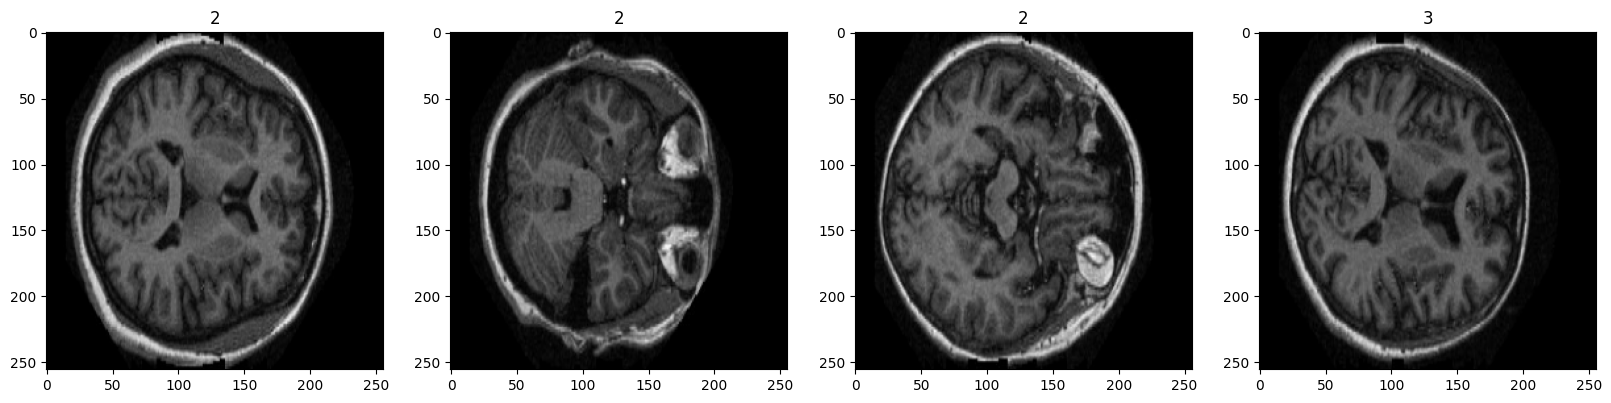

In [41]:
# fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# for idx, img in enumerate(batch[0][:4]):
#     ax[idx].imshow(img.astype(int))
#     ax[idx].title.set_text(batch[1][idx])

In [42]:
# # Shape of Images in the dataset
# batch[0][1].shape

(256, 256, 3)

In [43]:
# print(train_dataset.element_spec)

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [44]:

# from tensorflow.keras.utils import to_categorical

# # Assuming train_dataset and val_dataset
# num_classes = 4

# def preprocess_data(image, label):
#     # Convert label to one-hot encoding using tf.py_function
#     label = tf.py_function(lambda x: to_categorical(x, num_classes=num_classes), [label], tf.float32)
#     return image, label

# train_dataset = train_dataset.map(preprocess_data)
# val_dataset = val_dataset.map(preprocess_data)

## TRAINING BEGINS HERE
### TWO MODELS TESTED
### CUSTOM MODEL 1 (tm1)
### CUSTOM MODEL 2 (tm2)

In [13]:
# Assuming you have X_train_augmented, y_train_augmented, X_val, y_val, X_test, y_test

# Check the dimensions of the input datasets
print("Dimensions of the input datasets:")
print("X_train_augmented shape:", X_train_augmented.shape)
print("y_train_augmented shape:", y_train_augmented.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


Dimensions of the input datasets:
X_train_augmented shape: (5280, 150, 150, 3)
y_train_augmented shape: (5280, 4)
X_val shape: (1536, 150, 150, 3)
y_val shape: (1536, 4)
X_test shape: (384, 150, 150, 3)
y_test shape: (384, 4)


### ------------------------------------------------- PRONet-10 -------------------------------------------------


In [36]:
# PRONet-10
tm1 = Sequential()
tm1.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(128, 128, 3), padding='same'))
tm1.add(BatchNormalization())
tm1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

tm1.add(Conv2D(32, (3, 3), 1, activation='relu', padding='same'))
tm1.add(BatchNormalization())
tm1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
tm1.add(Dropout(0.4))

tm1.add(Conv2D(64, (3, 3), 1, activation='relu', padding='same'))
tm1.add(BatchNormalization())
tm1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
tm1.add(Dropout(0.4))

tm1.add(Flatten())
tm1.add(Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
tm1.add(Dropout(0.5))
tm1.add(Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
tm1.add(Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
tm1.add(Dense(4, activation="softmax"))

tm1.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 batch_normalization_3 (Batc  (None, 150, 150, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 batch_normalization_4 (Batc  (None, 75, 75, 32)       128       
 hNormalization)                                                 
                                                      

In [37]:
tm1.compile(optimizer='sgd', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [38]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [39]:
history = tm1.fit(
    X_train_augmented, y_train_augmented,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[tensorboard_callback]
)

Epoch 1/100
165/165 [==============================] - 4s 23ms/step - loss: 13.6010 - accuracy: 0.4979 - val_loss: 13.1972 - val_accuracy: 0.5143
Epoch 2/100
165/165 [==============================] - 4s 21ms/step - loss: 12.5845 - accuracy: 0.5769 - val_loss: 12.3194 - val_accuracy: 0.5195
Epoch 3/100
165/165 [==============================] - 3s 21ms/step - loss: 11.7982 - accuracy: 0.5992 - val_loss: 11.5552 - val_accuracy: 0.5208
Epoch 4/100
165/165 [==============================] - 3s 20ms/step - loss: 11.0785 - accuracy: 0.6030 - val_loss: 10.8824 - val_accuracy: 0.5111
Epoch 5/100
165/165 [==============================] - 3s 20ms/step - loss: 10.4021 - accuracy: 0.6095 - val_loss: 10.2159 - val_accuracy: 0.5423
Epoch 6/100
165/165 [==============================] - 3s 20ms/step - loss: 9.7843 - accuracy: 0.6241 - val_loss: 9.6475 - val_accuracy: 0.5326
Epoch 7/100
165/165 [==============================] - 3s 21ms/step - loss: 9.1993 - accuracy: 0.6216 - val_loss: 9.0644 - val

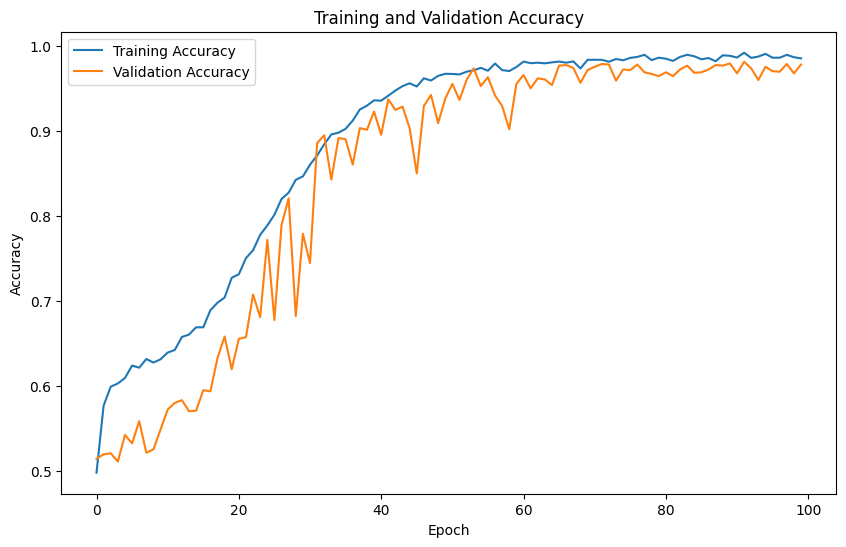

In [40]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
test_loss, test_accuracy = tm1.evaluate(X_test, y_test)

# Print the evaluation results
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

12/12 [==============================] - 0s 7ms/step - loss: 0.2790 - accuracy: 0.9844
Test Loss: 0.27897199988365173
Test Accuracy: 0.984375


In [26]:
tm1.save('tm21.h5')

### ------------------------------------------------- PRONet-5 -------------------------------------------------


In [42]:
# PRONet-5

tm2 = Sequential()
tm2.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape =(150,150,3), padding='same'))
tm2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

tm2.add(Conv2D(32, (3, 3), 1, activation='relu', padding='same'))
tm2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
tm2.add(Conv2D(64, (3, 3), 1, activation='relu', padding='same'))
tm2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
tm2.add(Dropout(0.5))

tm2.add(Flatten())
tm2.add(Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
tm2.add(Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
tm2.add(Dense(4, activation="softmax"))
tm2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 18, 18, 64)      

In [43]:
tm2.compile(optimizer='sgd', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [44]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [45]:
history = tm2.fit(
    X_train_augmented, y_train_augmented,
    epochs=70,
    validation_data=(X_val, y_val),
    callbacks=[tensorboard_callback]
)


Epoch 1/70
165/165 [==============================] - 3s 15ms/step - loss: 7.0105 - accuracy: 0.4650 - val_loss: 6.7414 - val_accuracy: 0.4701
Epoch 2/70
165/165 [==============================] - 2s 14ms/step - loss: 6.4306 - accuracy: 0.5625 - val_loss: 6.3775 - val_accuracy: 0.4212
Epoch 3/70
165/165 [==============================] - 2s 14ms/step - loss: 6.0368 - accuracy: 0.5841 - val_loss: 5.9741 - val_accuracy: 0.5234
Epoch 4/70
165/165 [==============================] - 2s 14ms/step - loss: 5.6776 - accuracy: 0.6047 - val_loss: 5.6268 - val_accuracy: 0.5312
Epoch 5/70
165/165 [==============================] - 2s 14ms/step - loss: 5.3430 - accuracy: 0.6146 - val_loss: 5.3214 - val_accuracy: 0.5469
Epoch 6/70
165/165 [==============================] - 2s 14ms/step - loss: 5.0269 - accuracy: 0.6258 - val_loss: 5.1120 - val_accuracy: 0.5254
Epoch 7/70
165/165 [==============================] - 2s 14ms/step - loss: 4.7408 - accuracy: 0.6475 - val_loss: 4.7316 - val_accuracy: 0.5684

In [46]:
test_loss, test_accuracy = tm2.evaluate(X_test, y_test)

# Print the evaluation results
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

12/12 [==============================] - 0s 5ms/step - loss: 0.2921 - accuracy: 0.9766
Test Loss: 0.29207348823547363
Test Accuracy: 0.9765625


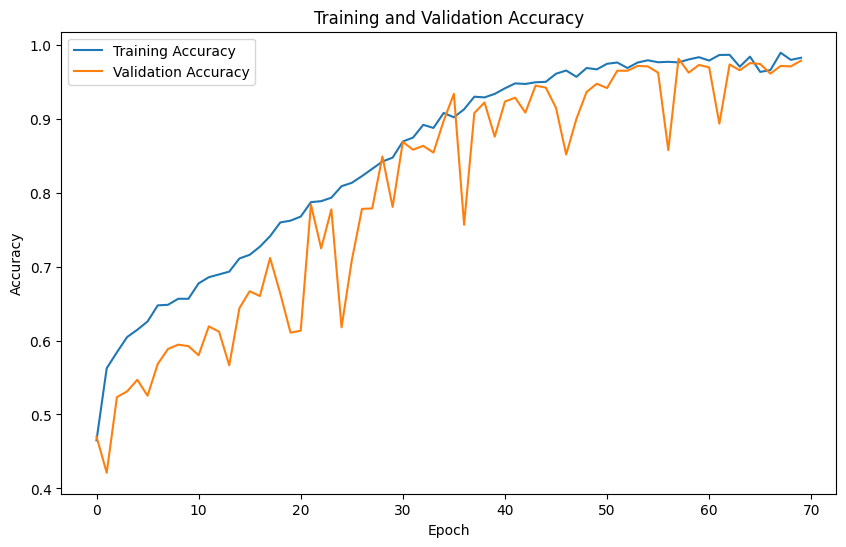

In [48]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [47]:
tm2.save('tm22.h5')